In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ST_results = pd.read_csv("ST_statewide.csv")
ST_results.head()

,State,Delegates,Biden,Sanders,Warren,Bloomberg,Other,Total
0,AL,52,286067,74867,25847,52750,12784,452315
1,AR,31,92998,51294,22918,38324,23865,229399
2,ME,24,67272,65037,31271,23827,10490,197897
3,MA,91,468746,371991,300026,164321,92138,1397222
4,MN,75,287552,222622,114795,62135,58084,745188


In [3]:
# default values from Morning Consult poll: 
#  https://morningconsult.com/2020/03/05/sanders-biden-can-expect-near-equal-gain-from-warrens-exit/
def split_warren_votes(pre_split_votes = ST_results, warren_to_biden = .36, warren_to_sanders = .43):
    # normalize (assume all EW supporters go either to JB or BS)
    biden_gain = warren_to_biden/(warren_to_biden + warren_to_sanders)
    sanders_gain = warren_to_sanders/(warren_to_biden + warren_to_sanders)
    post = pre_split_votes.copy()
    post.Biden = post.Biden + round(biden_gain * post.Warren)
    post.Sanders = post.Sanders + round(sanders_gain * post.Warren)
    post.Warren = 0
    return post

# apportion delegates according to 15% threshold rules
def apportion_delegates_threshold(votes = ST_results, threshold = 0.15):
    delegates = votes.copy()
    delegates = delegates.drop('Other', axis = 1)
    candidates = ['Biden', 'Sanders', 'Warren', 'Bloomberg']
    for c in candidates:
        delegates[c] = delegates[c]/delegates.Total
    delegates[candidates] = delegates[candidates].applymap(lambda x: x if x >= threshold else 0)
    delegates["viable_tot"] = delegates[candidates].sum(axis = 1)
    # DNC rules don't _quite_ just round, will fix this if I figure out how
    for c in candidates:
        delegates[c] = round((delegates[c]/delegates.viable_tot) * delegates['Delegates'])
    delegates = delegates.drop('viable_tot', axis = 1)
    return delegates
    

# apportion delegates purely proportionally (just a shortcut)
def apportion_delegates_prop(votes = ST_results):
    return apportion_delegates_threshold(votes = votes, threshold = 0)

# get the biden net delegate gain
def get_biden_net(split, votes = ST_results, threshold = 0.15):
    post_split = split_warren_votes(pre_split_votes = votes, warren_to_biden = split, warren_to_sanders = 1 - split)
    dels = apportion_delegates_threshold(votes = post_split)
    return sum(dels.Biden) - sum(dels.Sanders)

In [4]:
splits = np.linspace(0,1,101)
net_dels_biden = []
for split in splits:
    net_dels_biden.append(get_biden_net(split))

In [5]:
net_dels_biden_no_threshold = []
for split in splits:
    post_split = split_warren_votes(warren_to_biden = split, warren_to_sanders = 1 - split)
    dels = apportion_delegates_threshold(votes = post_split, threshold = 0)
    net = sum(dels.Biden) - sum(dels.Sanders)
    net_dels_biden_no_threshold.append(net)

In [6]:
# according to the Morning Consult poll
post_split = split_warren_votes()
morning_consult = apportion_delegates_threshold(post_split)
biden_dels = sum(morning_consult['Biden'])
sanders_dels = sum(morning_consult['Sanders'])
morning_consult_net = biden_dels - sanders_dels

mc_undecideds_equal = .4557
mc_undecideds_sanders = .36
intersects = [net_dels_biden[round(mc_undecideds_equal * 100)], net_dels_biden[round(mc_undecideds_sanders * 100)]]
ST_actual_net = 97

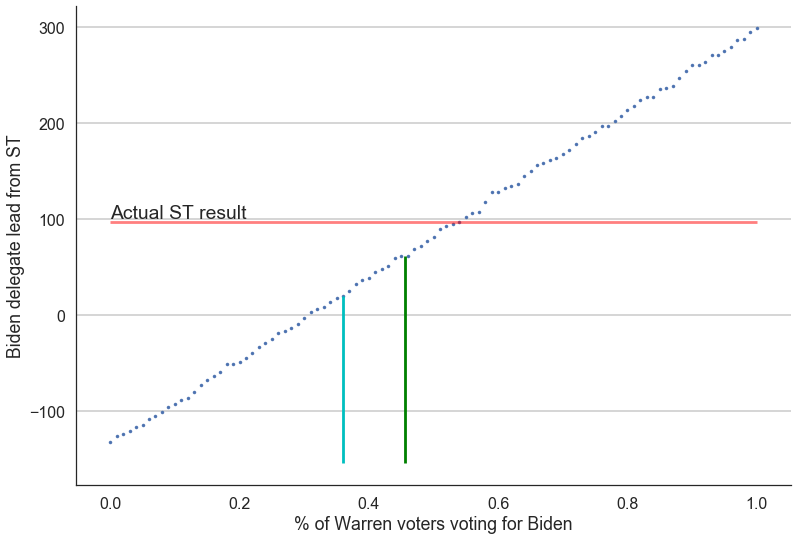

In [7]:
with sns.plotting_context("poster"):
    sns.set_style('white')
    plt.scatter(splits, net_dels_biden, s = 9)
    plt.ylabel("Biden delegate lead from ST")
    plt.xlabel("% of Warren voters voting for Biden")
    plt.hlines(ST_actual_net, 0, 1, color = 'red', alpha = 0.5, label = 'Actual ST result')
    plt.text(0, ST_actual_net + 4, "Actual ST result")
    plt.vlines([mc_undecideds_equal, mc_undecideds_sanders], plt.ylim()[0], intersects, color = ['g', 'c'])
    plt.grid(which = 'major', axis = 'y')
    sns.despine()
    plt.show()

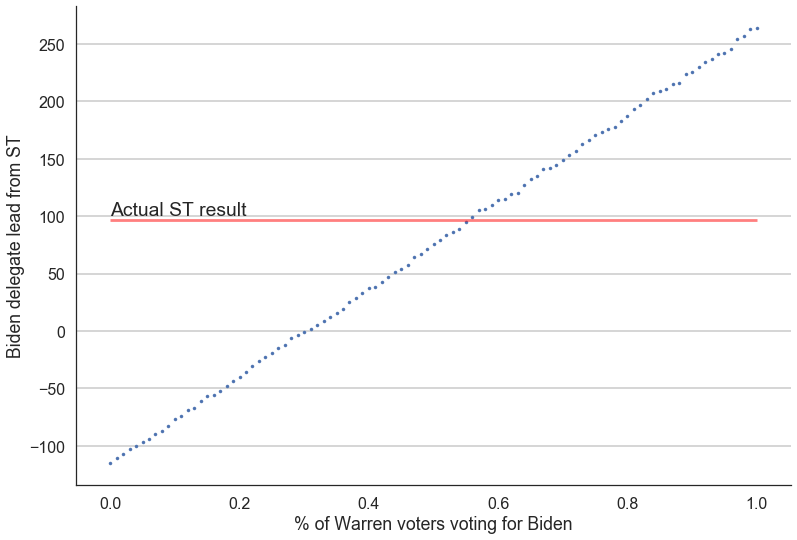

In [9]:
with sns.plotting_context("poster"):
    sns.set_style('white')
    plt.scatter(splits, net_dels_biden_no_threshold, s = 9)
    plt.ylabel("Biden delegate lead from ST")
    plt.xlabel("% of Warren voters voting for Biden")
    plt.hlines(ST_actual_net, 0, 1, color = 'red', alpha = 0.5, label = 'Actual ST result')
    plt.text(0, ST_actual_net + 4, "Actual ST result")
    plt.grid(which = 'major', axis = 'y')
    sns.despine()
    plt.show()
    plt.savefig('no_threshold.png')